# Forecasting using previous years as a baseline

See my EDA and Linear Regression baseline notebook for more information about this dataset:
- https://www.kaggle.com/code/cabaxiom/s5e1-eda-and-linear-regression-baseline?scriptVersionId=216127469

This forecast contains much of the same first steps as my previous notebook - aggregating on country, product and store, then making the forecast for the daily number of sales for the next three years, before disagregating back to get the number of sales for each country, product and store.

**Forecast:**

The forecast in this notebook takes the mean number of sales for each day of the year for the previous x years and uses this as the forecast. **No model is used**.

Day of the week has been considered.

### Preliminaries

In [41]:
#  pip install kaggle
# kaggle competitions list

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [43]:
import warnings
import os
import plotly.graph_objects as go

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")
os.listdir()

['datadown',
 'emsembler.ipynb',
 'forecasting-sticker-sales-ensemble.ipynb',
 'linearregression-subtract-bias-makes-lb-0-054.ipynb',
 'models',
 's5e1-previous-years-baseline-no-model.ipynb',
 'submissions',
 'submissions2']

In [44]:
try:
    train_df = pd.read_csv("/kaggle/input/playground-series-s5e1/train.csv", parse_dates=["date"])
    test_df = pd.read_csv("/kaggle/input/playground-series-s5e1/test.csv", parse_dates=["date"])
except:
    train_df = pd.read_csv("./datadown/train.csv", parse_dates=["date"])
    test_df = pd.read_csv("./datadown/test.csv", parse_dates=["date"])


In [45]:
print("Train - Earliest date:", train_df["date"].min())
print("Train - Latest date:", train_df["date"].max())

print("Test - Earliest date:", test_df["date"].min())
print("Test - Latest date:", test_df["date"].max())

Train - Earliest date: 2010-01-01 00:00:00
Train - Latest date: 2016-12-31 00:00:00
Test - Earliest date: 2017-01-01 00:00:00
Test - Latest date: 2019-12-31 00:00:00


In [46]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("zgrcemta/world-gdpgdp-gdp-per-capita-and-annual-growths")

# print("Path to dataset files:", path)

## Country Weights

We aggregate the country variable when making the forecast as we found in my EDA [notebook](https://www.kaggle.com/code/cabaxiom/s5e1-eda-and-linear-regression-baseline?scriptVersionId=216127469). This works as the proportion of sales in each country for every year is equal to the proportion of GDP per captia for that country and year.

In [47]:
gdp_per_capita_df = pd.read_csv("./datadown/gdp_per_capita.csv")

years =  ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"]
gdp_per_capita_filtered_df = gdp_per_capita_df.loc[gdp_per_capita_df["Country Name"].isin(train_df["country"].unique()), ["Country Name"] + years].set_index("Country Name")
gdp_per_capita_filtered_df["2010_ratio"] = gdp_per_capita_filtered_df["2010"] / gdp_per_capita_filtered_df.sum()["2010"]
for year in years:
    gdp_per_capita_filtered_df[f"{year}_ratio"] = gdp_per_capita_filtered_df[year] / gdp_per_capita_filtered_df.sum()[year]
gdp_per_capita_filtered_ratios_df = gdp_per_capita_filtered_df[[i+"_ratio" for i in years]]
gdp_per_capita_filtered_ratios_df.columns = [int(i) for i in years]
gdp_per_capita_filtered_ratios_df = gdp_per_capita_filtered_ratios_df.unstack().reset_index().rename(columns = {"level_0": "year", 0: "ratio", "Country Name": "country"})
gdp_per_capita_filtered_ratios_df['year'] = pd.to_datetime(gdp_per_capita_filtered_ratios_df['year'], format='%Y')

## Imputing Missing Values

Imputing missing values, using this information.

In [48]:
print(train_df['country'].unique())
gdp_per_capita_filtered_ratios_df.loc[
        (gdp_per_capita_filtered_ratios_df["year"] == year)
        & (gdp_per_capita_filtered_ratios_df["country"] == "Finland"),
        "ratio",
    ].values[
        0
    ]  /gdp_per_capita_filtered_ratios_df.loc[
        (gdp_per_capita_filtered_ratios_df["year"] == year)
        & (gdp_per_capita_filtered_ratios_df["country"] == "Canada"),
        "ratio",
    ].values[0]

['Canada' 'Finland' 'Italy' 'Kenya' 'Norway' 'Singapore']


1.125889461973288

In [49]:
train_df["year"] = train_df["date"].dt.year

train_df.loc[
        (train_df["country"] == "Canada")
        & (train_df["store"] == "Discount Stickers")
        & (train_df["product"] == "Holographic Goose")
        & (train_df["year"] == year),
        :
    ]

,id,date,country,store,product,num_sold,year


In [50]:
gdp_per_capita_filtered_ratios_df["year"] = gdp_per_capita_filtered_ratios_df[
    "year"
].dt.year
train_df_imputed = train_df.copy()
print(f"Missing values remaining: {train_df_imputed['num_sold'].isna().sum()}")

train_df_imputed["year"] = train_df_imputed["date"].dt.year
for year in train_df_imputed["year"].unique():
    # Impute Time Series 1 (Canada, Discount Stickers, Holographic Goose)
    target_ratio = gdp_per_capita_filtered_ratios_df.loc[
        (gdp_per_capita_filtered_ratios_df["year"] == year)
        & (gdp_per_capita_filtered_ratios_df["country"] == "Norway"),
        "ratio",
    ].values[
        0
    ]  #* Using Norway as should have the best precision
    current_raito = gdp_per_capita_filtered_ratios_df.loc[
        (gdp_per_capita_filtered_ratios_df["year"] == year)
        & (gdp_per_capita_filtered_ratios_df["country"] == "Canada"),
        "ratio",
    ].values[0]
    ratio_can = current_raito / target_ratio
    train_df_imputed.loc[
        (train_df_imputed["country"] == "Canada")
        & (train_df_imputed["store"] == "Discount Stickers")
        & (train_df_imputed["product"] == "Holographic Goose")
        & (train_df_imputed["year"] == year),
        "num_sold",
    ] = (
        train_df_imputed.loc[
            (train_df_imputed["country"] == "Norway")
            & (train_df_imputed["store"] == "Discount Stickers")
            & (train_df_imputed["product"] == "Holographic Goose")
            & (train_df_imputed["year"] == year),
            "num_sold",
        ]
        * ratio_can
    ).values

    # Impute Time Series 2 (Only Missing Values)
    current_ts = train_df_imputed.loc[
        (train_df_imputed["country"] == "Canada")
        & (train_df_imputed["store"] == "Premium Sticker Mart")
        & (train_df_imputed["product"] == "Holographic Goose")
        & (train_df_imputed["year"] == year)
    ]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[
        (train_df_imputed["country"] == "Canada")
        & (train_df_imputed["store"] == "Premium Sticker Mart")
        & (train_df_imputed["product"] == "Holographic Goose")
        & (train_df_imputed["year"] == year)
        & (train_df_imputed["date"].isin(missing_ts_dates)),
        "num_sold",
    ] = (
        train_df_imputed.loc[
            (train_df_imputed["country"] == "Norway")
            & (train_df_imputed["store"] == "Premium Sticker Mart")
            & (train_df_imputed["product"] == "Holographic Goose")
            & (train_df_imputed["year"] == year)
            & (train_df_imputed["date"].isin(missing_ts_dates)),
            "num_sold",
        ]
        * ratio_can
    ).values

    # Impute Time Series 3 (Only Missing Values)
    current_ts = train_df_imputed.loc[
        (train_df_imputed["country"] == "Canada")
        & (train_df_imputed["store"] == "Stickers for Less")
        & (train_df_imputed["product"] == "Holographic Goose")
        & (train_df_imputed["year"] == year)
    ]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[
        (train_df_imputed["country"] == "Canada")
        & (train_df_imputed["store"] == "Stickers for Less")
        & (train_df_imputed["product"] == "Holographic Goose")
        & (train_df_imputed["year"] == year)
        & (train_df_imputed["date"].isin(missing_ts_dates)),
        "num_sold",
    ] = (
        train_df_imputed.loc[
            (train_df_imputed["country"] == "Norway")
            & (train_df_imputed["store"] == "Stickers for Less")
            & (train_df_imputed["product"] == "Holographic Goose")
            & (train_df_imputed["year"] == year)
            & (train_df_imputed["date"].isin(missing_ts_dates)),
            "num_sold",
        ]
        * ratio_can
    ).values

    # Impute Time Series 4 (Kenya, Discount Stickers, Holographic Goose)
    current_raito = gdp_per_capita_filtered_ratios_df.loc[
        (gdp_per_capita_filtered_ratios_df["year"] == year)
        & (gdp_per_capita_filtered_ratios_df["country"] == "Kenya"),
        "ratio",
    ].values[0]
    ratio_ken = current_raito / target_ratio
    train_df_imputed.loc[
        (train_df_imputed["country"] == "Kenya")
        & (train_df_imputed["store"] == "Discount Stickers")
        & (train_df_imputed["product"] == "Holographic Goose")
        & (train_df_imputed["year"] == year),
        "num_sold",
    ] = (
        train_df_imputed.loc[
            (train_df_imputed["country"] == "Norway")
            & (train_df_imputed["store"] == "Discount Stickers")
            & (train_df_imputed["product"] == "Holographic Goose")
            & (train_df_imputed["year"] == year),
            "num_sold",
        ]
        * ratio_ken
    ).values

    # Impute Time Series 5 (Only Missing Values)
    current_ts = train_df_imputed.loc[
        (train_df_imputed["country"] == "Kenya")
        & (train_df_imputed["store"] == "Premium Sticker Mart")
        & (train_df_imputed["product"] == "Holographic Goose")
        & (train_df_imputed["year"] == year)
    ]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[
        (train_df_imputed["country"] == "Kenya")
        & (train_df_imputed["store"] == "Premium Sticker Mart")
        & (train_df_imputed["product"] == "Holographic Goose")
        & (train_df_imputed["year"] == year)
        & (train_df_imputed["date"].isin(missing_ts_dates)),
        "num_sold",
    ] = (
        train_df_imputed.loc[
            (train_df_imputed["country"] == "Norway")
            & (train_df_imputed["store"] == "Premium Sticker Mart")
            & (train_df_imputed["product"] == "Holographic Goose")
            & (train_df_imputed["year"] == year)
            & (train_df_imputed["date"].isin(missing_ts_dates)),
            "num_sold",
        ]
        * ratio_ken
    ).values

    # Impute Time Series 6 (Only Missing Values)
    current_ts = train_df_imputed.loc[
        (train_df_imputed["country"] == "Kenya")
        & (train_df_imputed["store"] == "Stickers for Less")
        & (train_df_imputed["product"] == "Holographic Goose")
        & (train_df_imputed["year"] == year)
    ]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[
        (train_df_imputed["country"] == "Kenya")
        & (train_df_imputed["store"] == "Stickers for Less")
        & (train_df_imputed["product"] == "Holographic Goose")
        & (train_df_imputed["year"] == year)
        & (train_df_imputed["date"].isin(missing_ts_dates)),
        "num_sold",
    ] = (
        train_df_imputed.loc[
            (train_df_imputed["country"] == "Norway")
            & (train_df_imputed["store"] == "Stickers for Less")
            & (train_df_imputed["product"] == "Holographic Goose")
            & (train_df_imputed["year"] == year)
            & (train_df_imputed["date"].isin(missing_ts_dates)),
            "num_sold",
        ]
        * ratio_ken
    ).values

    # Impute Time Series 7 (Only Missing Values)
    current_ts = train_df_imputed.loc[
        (train_df_imputed["country"] == "Kenya")
        & (train_df_imputed["store"] == "Discount Stickers")
        & (train_df_imputed["product"] == "Kerneler")
        & (train_df_imputed["year"] == year)
    ]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[
        (train_df_imputed["country"] == "Kenya")
        & (train_df_imputed["store"] == "Discount Stickers")
        & (train_df_imputed["product"] == "Kerneler")
        & (train_df_imputed["year"] == year)
        & (train_df_imputed["date"].isin(missing_ts_dates)),
        "num_sold",
    ] = (
        train_df_imputed.loc[
            (train_df_imputed["country"] == "Norway")
            & (train_df_imputed["store"] == "Discount Stickers")
            & (train_df_imputed["product"] == "Kerneler")
            & (train_df_imputed["year"] == year)
            & (train_df_imputed["date"].isin(missing_ts_dates)),
            "num_sold",
        ]
        * ratio_ken
    ).values

print(f"Missing values remaining: {train_df_imputed['num_sold'].isna().sum()}")

Missing values remaining: 8871
Missing values remaining: 2


In [51]:
missing_rows = train_df_imputed.loc[train_df_imputed["num_sold"].isna()]

train_df_imputed.loc[train_df_imputed["id"] == 23719, "num_sold"] = 4
train_df_imputed.loc[train_df_imputed["id"] == 207003, "num_sold"] = 195

print(f"Missing values remaining: {train_df_imputed['num_sold'].isna().sum()}")

Missing values remaining: 0


## Store Weights

We aggregate the stores, as we found that each store has the same proportion of sales on every day during the EDA.

In [52]:
store_weights = train_df_imputed.groupby("store")["num_sold"].sum()/train_df_imputed["num_sold"].sum()

## Product Weights

We aggregate over products, as we found during the EDA that the proportion of sales for each product can be fitted with a trigonometric function.

In [53]:
product_df = train_df_imputed.groupby(["date","product"])["num_sold"].sum().reset_index()
product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("ratios").reset_index()


product_ratio_2017_df = product_ratio_df.loc[product_ratio_df["date"].dt.year == 2015].copy()
product_ratio_2018_df = product_ratio_df.loc[product_ratio_df["date"].dt.year == 2016].copy()
product_ratio_2019_df = product_ratio_df.loc[product_ratio_df["date"].dt.year == 2015].copy()

product_ratio_2017_df["date"] = product_ratio_2017_df["date"] + pd.DateOffset(years=2)
product_ratio_2018_df["date"] = product_ratio_2018_df["date"] + pd.DateOffset(years=2)
product_ratio_2019_df["date"] =  product_ratio_2019_df["date"] + pd.DateOffset(years=4)

forecasted_ratios_df = pd.concat([product_ratio_2017_df, product_ratio_2018_df, product_ratio_2019_df])



## Aggregating Time Series

Making the aggregation over all countries, stores and products, obtaining the total sales each day as our new time series that we want to forecast.

In [54]:
original_train_df_imputed = train_df_imputed.copy()
train_df_imputed = train_df_imputed.groupby(["date"])["num_sold"].sum().reset_index()

Lets have a look at the number of sales each day over time:

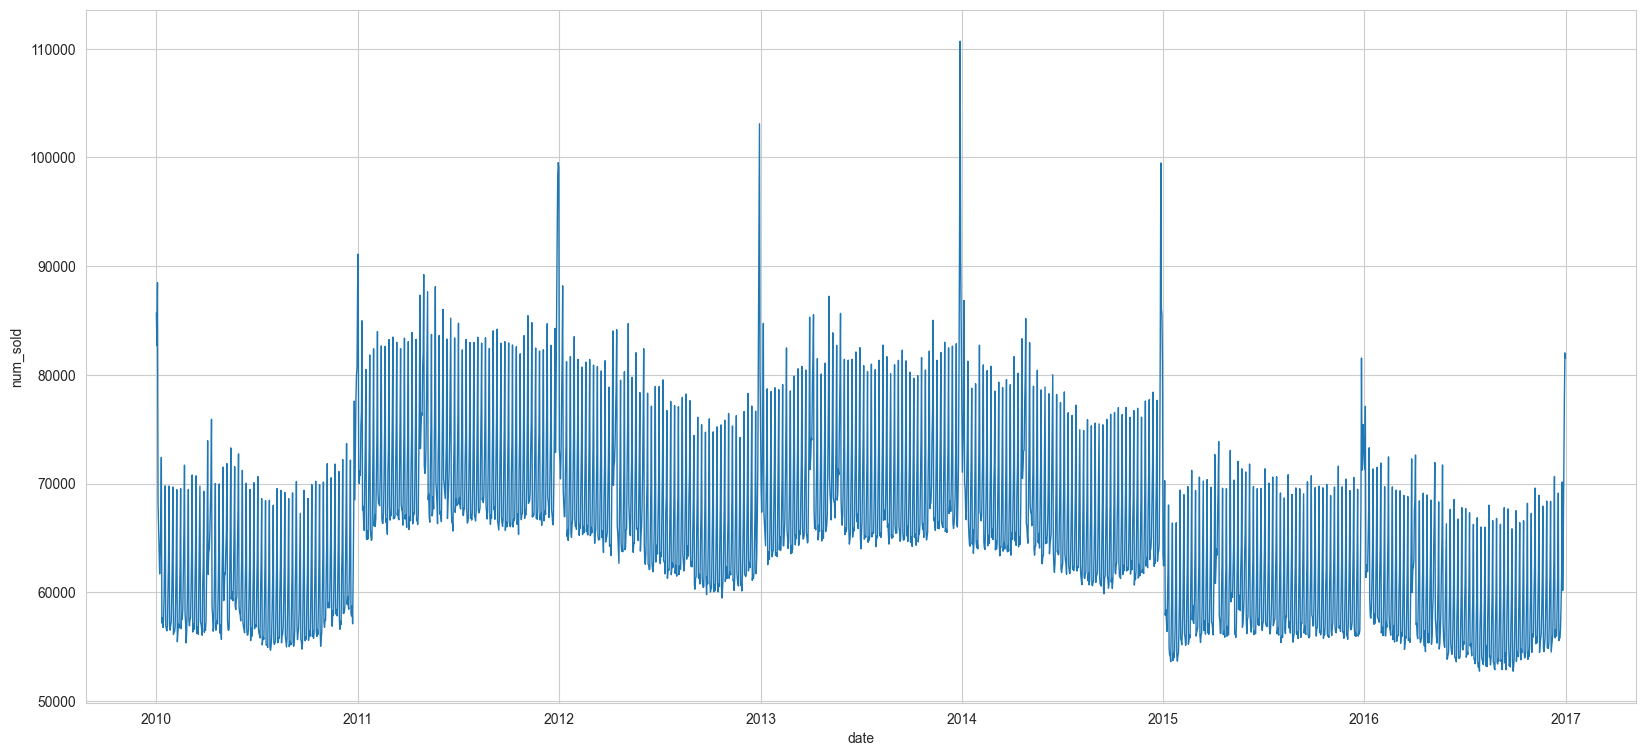

In [55]:
f,ax = plt.subplots(figsize=(20,9))
sns.lineplot(data=train_df_imputed, x="date", y="num_sold", linewidth = 1);

In [56]:
train_df_imputed["year"] = train_df_imputed["date"].dt.year
train_df_imputed["month"] = train_df_imputed["date"].dt.month
train_df_imputed["day"] = train_df_imputed["date"].dt.day
train_df_imputed["day_of_week"] = train_df_imputed["date"].dt.dayofweek

In [57]:
#get the dates to forecast for
test_total_sales_df = test_df.groupby(["date"])["id"].first().reset_index().drop(columns="id")

test_total_sales_df["month"] = test_total_sales_df["date"].dt.month
test_total_sales_df["day"] = test_total_sales_df["date"].dt.day
test_total_sales_df["day_of_week"] = test_total_sales_df["date"].dt.day_of_week

Account for day of week in the forecast by removing its effect on the number of sales. For example Sataurday has more sales than other days, so we multipy it by a number less than 1, to try and take the variation caused by day of the week out.Thus standardising the number of sales by the day of week.

In [58]:
day_of_week_ratio = (train_df_imputed.groupby("day_of_week")["num_sold"].mean() / train_df_imputed.groupby("day_of_week")["num_sold"].mean().mean()).rename("day_of_week_ratios")
display(day_of_week_ratio)
train_df_imputed = pd.merge(train_df_imputed, day_of_week_ratio, how="left", on="day_of_week")
train_df_imputed["adjusted_num_sold"] = train_df_imputed["num_sold"] / train_df_imputed["day_of_week_ratios"]

day_of_week
0    0.943221
1    0.943352
2    0.943859
3    0.943747
4    1.000503
5    1.056331
6    1.168988
Name: day_of_week_ratios, dtype: float64

Ignore this, its just to check we didn't make a mistake when standardising:

In [59]:
sanity_check = (train_df_imputed["num_sold"].sum() - train_df_imputed["adjusted_num_sold"].sum()) / train_df_imputed["num_sold"].sum()
print(f"This number should be very small {sanity_check:.6f}")

This number should be very small 0.000022


## Making the forecast

We make the forecast by taking the mean number of sales for that day of the year over the past x years. it's probably a good idea to use the full data, but if any trends exist over time it might be best to only use the past few years. Feel free to experiment with this value.

In [60]:
train_last_x_years_df = train_df_imputed.loc[train_df_imputed["year"] >= 2010]
train_day_mean_df = train_last_x_years_df.groupby(["month", "day"])["adjusted_num_sold"].mean().reset_index()

In [61]:
test_total_sales_df = pd.merge(test_total_sales_df, train_day_mean_df, how="left", on=["month", "day"])
# Applying the day of week ratios back, thus increasing the number of sales if its a Sataurday for example
test_total_sales_df = pd.merge(test_total_sales_df, day_of_week_ratio.reset_index(), how="left", on="day_of_week")
test_total_sales_df["num_sold"] = test_total_sales_df["adjusted_num_sold"] * test_total_sales_df["day_of_week_ratios"]

Lets take a look at our forecast:

In [69]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = pd.concat([train_df_imputed,test_total_sales_df]).reset_index(drop=True), x="date", y="num_sold", linewidth=0.6);
ax.axvline(pd.to_datetime("2017-01-01"), color='black', linestyle='--');

## Disaggregating Total Sales Forecast

We need to divide the total sales forecast for each day between the categorical variables so we get the forecast for each day, country, product and store.

In [81]:
store_weights_df

,store,num_sold
0,Discount Stickers,0.184716
1,Premium Sticker Mart,0.441564
2,Stickers for Less,0.373720


In [89]:
product_ratio_df

,date,product,ratios
0,2010-01-01,Holographic Goose,0.052441
1,2010-01-01,Kaggle,0.329305
2,2010-01-01,Kaggle Tiers,0.291165
3,2010-01-01,Kerneler,0.152373
4,2010-01-01,Kerneler Dark Mode,0.174715
...,...,...,...
12780,2016-12-31,Holographic Goose,0.053591
12781,2016-12-31,Kaggle,0.339649
12782,2016-12-31,Kaggle Tiers,0.270557
12783,2016-12-31,Kerneler,0.152138


In [90]:
forecasted_ratios_df

,date,product,ratios
9130,2017-01-01,Holographic Goose,0.053755
9131,2017-01-01,Kaggle,0.350044
9132,2017-01-01,Kaggle Tiers,0.263057
9133,2017-01-01,Kerneler,0.155640
9134,2017-01-01,Kerneler Dark Mode,0.177505
...,...,...,...
10950,2019-12-31,Holographic Goose,0.050794
10951,2019-12-31,Kaggle,0.331864
10952,2019-12-31,Kaggle Tiers,0.290504
10953,2019-12-31,Kerneler,0.153052


In [74]:
train_df_imputed

,date,num_sold,year,month,day,day_of_week,day_of_week_ratios,adjusted_num_sold
0,2010-01-01,85710.772635,2010,1,1,4,1.000503,85667.714526
1,2010-01-02,82699.983533,2010,1,2,5,1.056331,78289.810336
2,2010-01-03,88476.100742,2010,1,3,6,1.168988,75686.079816
3,2010-01-04,68206.949986,2010,1,4,0,0.943221,72312.817158
4,2010-01-05,65832.192575,2010,1,5,1,0.943352,69785.397279
...,...,...,...,...,...,...,...,...
2552,2016-12-27,64651.885691,2016,12,27,1,0.943352,68534.213297
2553,2016-12-28,71252.729934,2016,12,28,2,0.943859,75490.883501
2554,2016-12-29,77548.729112,2016,12,29,3,0.943747,82171.119774
2555,2016-12-30,82028.751480,2016,12,30,4,1.000503,81987.543090


In [95]:
train_df.merge(train_df_imputed, on = ['date', 'year'], suffixes=['', '_imputed'])

,id,date,country,store,product,num_sold,year,num_sold_imputed,month,day,day_of_week,day_of_week_ratios,adjusted_num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,2010,85710.772635,1,1,4,1.000503,85667.714526
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010,85710.772635,1,1,4,1.000503,85667.714526
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,85710.772635,1,1,4,1.000503,85667.714526
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010,85710.772635,1,1,4,1.000503,85667.714526
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,85710.772635,1,1,4,1.000503,85667.714526
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,2016,81557.796217,12,31,5,1.056331,77208.532874
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,2016,81557.796217,12,31,5,1.056331,77208.532874
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,2016,81557.796217,12,31,5,1.056331,77208.532874
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0,2016,81557.796217,12,31,5,1.056331,77208.532874


In [85]:
test_sub_df.drop(train_df_imputed.columns.tolist(), axis = 1 )

,id,country,store,product,day_num_sold,store_ratio,country_ratio,product_ratio
0,230130,Canada,Discount Stickers,Holographic Goose,92574.406016,0.184716,0.172210,0.053755
1,230131,Canada,Discount Stickers,Kaggle,92574.406016,0.184716,0.172210,0.350044
2,230132,Canada,Discount Stickers,Kaggle Tiers,92574.406016,0.184716,0.172210,0.263057
3,230133,Canada,Discount Stickers,Kerneler,92574.406016,0.184716,0.172210,0.155640
4,230134,Canada,Discount Stickers,Kerneler Dark Mode,92574.406016,0.184716,0.172210,0.177505
...,...,...,...,...,...,...,...,...
98635,328675,Singapore,Premium Sticker Mart,Holographic Goose,79380.872665,0.441564,0.241431,0.050794
98636,328676,Singapore,Premium Sticker Mart,Kaggle,79380.872665,0.441564,0.241431,0.331864
98637,328677,Singapore,Premium Sticker Mart,Kaggle Tiers,79380.872665,0.441564,0.241431,0.290504
98638,328678,Singapore,Premium Sticker Mart,Kerneler,79380.872665,0.441564,0.241431,0.153052


In [92]:
test_total_sales_df

,date,month,day,day_of_week,adjusted_num_sold,day_of_week_ratios,num_sold
0,2017-01-01,1,1,6,79191.937980,1.168988,92574.406016
1,2017-01-02,1,2,0,73221.589546,0.943221,69064.122964
2,2017-01-03,1,3,1,71386.834673,0.943352,67342.911709
3,2017-01-04,1,4,2,70004.853657,0.943859,66074.692736
4,2017-01-05,1,5,3,70718.684490,0.943747,66740.530270
...,...,...,...,...,...,...,...
1090,2019-12-27,12,27,4,75659.685788,1.000503,75697.713685
1091,2019-12-28,12,28,5,82394.840169,1.056331,87036.255369
1092,2019-12-29,12,29,6,87883.775483,1.168988,102735.057650
1093,2019-12-30,12,30,0,88565.453618,0.943221,83536.774017


In [63]:
# Adding in the store ratios
store_weights_df = store_weights.reset_index()
test_sub_df = pd.merge(test_df, test_total_sales_df, how="left", on="date")
test_sub_df = test_sub_df.rename(columns = {"num_sold":"day_num_sold"})
# Adding in the product ratios
test_sub_df = pd.merge(test_sub_df, store_weights_df, how="left", on="store")
test_sub_df = test_sub_df.rename(columns = {"num_sold":"store_ratio"})
# Adding in the country ratios
test_sub_df["year"] = test_sub_df["date"].dt.year
test_sub_df = pd.merge(test_sub_df, gdp_per_capita_filtered_ratios_df, how="left", on=["year", "country"])
test_sub_df = test_sub_df.rename(columns = {"ratio":"country_ratio"})
# Adding in the product ratio
test_sub_df = pd.merge(test_sub_df, forecasted_ratios_df, how="left", on=["date", "product"])
test_sub_df = test_sub_df.rename(columns = {"ratios":"product_ratio"})

# Disaggregating the forecast
test_sub_df["num_sold"] = test_sub_df["day_num_sold"] * test_sub_df["store_ratio"] * test_sub_df["country_ratio"] * test_sub_df["product_ratio"]
test_sub_df["num_sold"] = test_sub_df["num_sold"].round()

In [64]:
def plot_individual_ts(df):
    colour_map = {"Canada": "blue", "Finland": "orange", "Italy": "green", "Kenya":"red", "Norway": "purple", "Singapore": "brown"}
    for country in df["country"].unique():
        f,axes = plt.subplots(df["store"].nunique()*df["product"].nunique(),figsize=(20,70))
        count = 0
        for store in df["store"].unique():
            for product in df["product"].unique():
                plot_df = df.loc[(df["product"] == product) & (df["country"] == country) & (df["store"] == store)]
                sns.lineplot(data = plot_df, x="date", y="num_sold", linewidth=0.5, ax=axes[count], color=colour_map[country])
                axes[count].set_title(f"{country} - {store} - {product}")
                axes[count].axvline(pd.to_datetime("2017-01-01"), color='black', linestyle='--')
                count+=1

Lets take a look at each of the 90 time series to see if the forecasts look reasonable:

KeyboardInterrupt: 

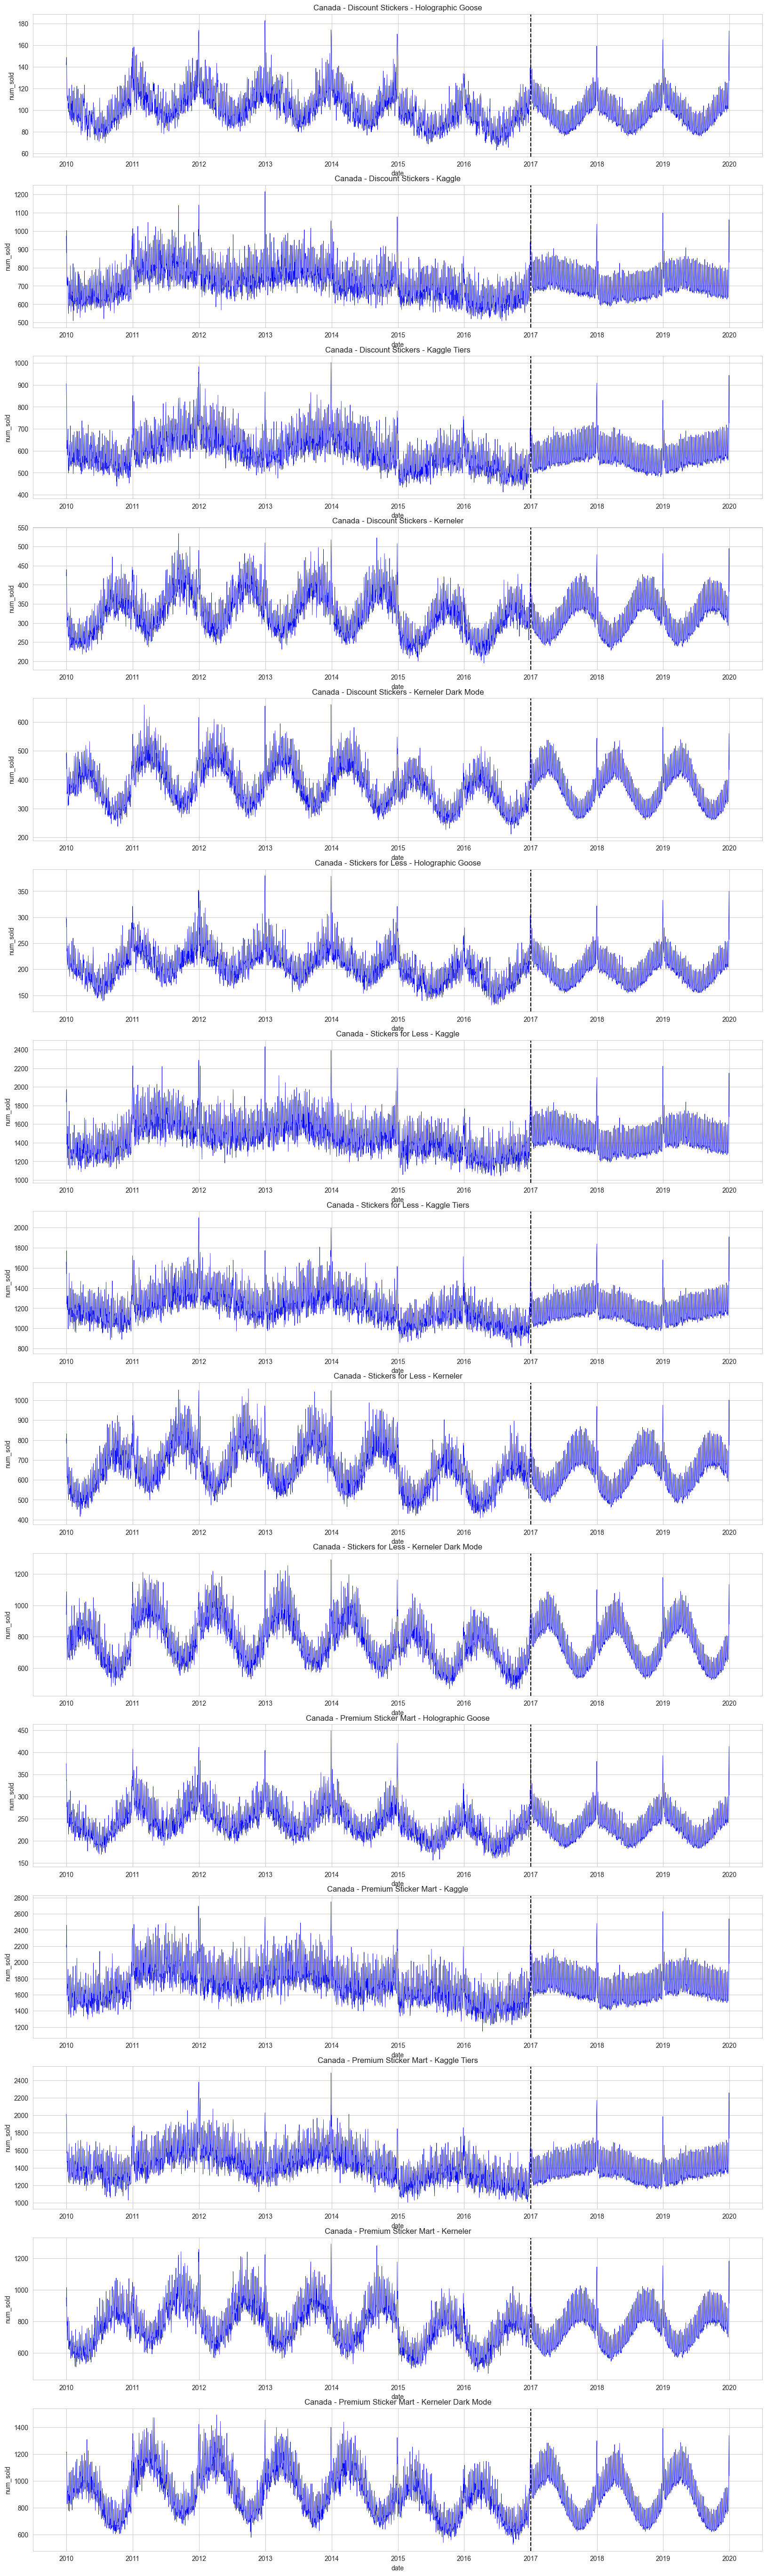

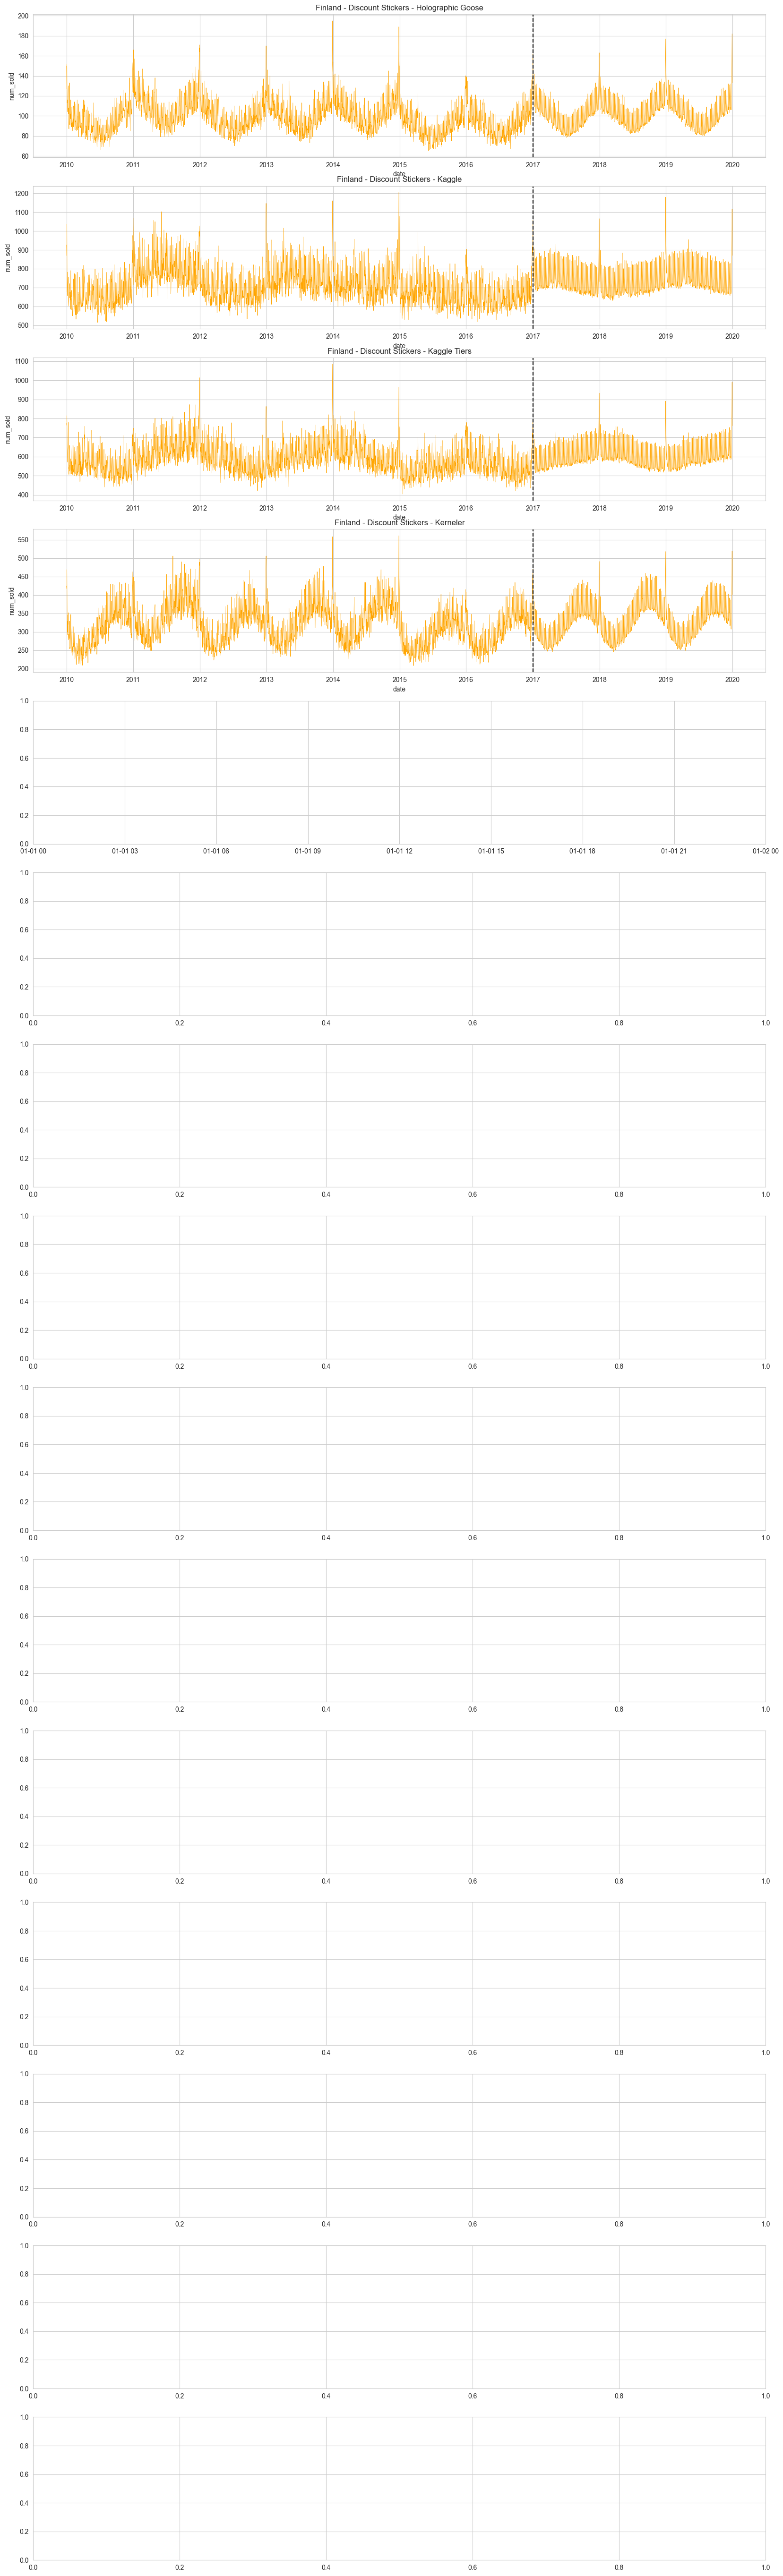

In [65]:
plot_individual_ts(pd.concat([original_train_df_imputed,test_sub_df]).reset_index(drop=True))

## Submission

In [66]:
# submission = pd.read_csv("/kaggle/input/playground-series-s5e1/sample_submission.csv")
submission = pd.read_csv("./datadown/sample_submission.csv")
submission["num_sold"] = test_sub_df["num_sold"]

# submission.to_csv('submission.csv', index = False)

# display(submission.head(2))

In [68]:
submission.to_csv("./submission_0/sub_nomodel.csv", index = None)